In [1]:
import sys
sys.path.append('../')
from src.load_data import *
from src.realtime_utils import *
from src.plot_functions import *

In [2]:
from plotnine import *

In [3]:
files = glob.glob(f'../data/nowcasts/KIT-baseline/*.csv') 

In [4]:
dfs = []
for file in files:
    df_temp = pd.read_csv(file, parse_dates=['forecast_date', 'target_end_date'])
    df_temp['model'] = file[:-4].split('/')[-1].split('-', 5)[-1]
    dfs.append(df_temp)
df = pd.concat(dfs)

In [5]:
start='2023-11-16'
end='2024-09-19'

In [6]:
df = df[df.forecast_date.between(start, end)]

In [7]:
target_sari = load_target_series('sari')

In [8]:
df = df[df.type == 'quantile']

In [9]:
df_plot = prepare_plot_data(df, target_sari)

In [10]:
def load_frozen_values(horizon):
    rt = load_rt(preprocessed=False)
    rt = rt.dropna()
    rt['value'] = rt.loc[:, 'value_0w' : f'value_{-1*horizon}w'].sum(axis=1)
    return rt[[c for c in rt.columns if 'value_' not in c]]

In [11]:
def plot_nowcasts(plot_data, stratum='national', horizon=0):
    df_frozen = load_frozen_values(horizon)

    if stratum == 'national':
        plotnine.options.figure_size = (6, 2.5)
        df_temp = plot_data[(plot_data.location == 'DE') & (plot_data.age_group == '00+')]
        frozen_temp = df_frozen[(df_frozen.location == 'DE') & (df_frozen.age_group == '00+')]
        facet = 'location'
        ncol = 1
        
    elif stratum == 'age':
        plotnine.options.figure_size = (12, 5)
        df_temp = plot_data[(plot_data.location == 'DE') & (plot_data.age_group != '00+')]
        frozen_temp = df_frozen[(df_frozen.location == 'DE') & (df_frozen.age_group != '00+')]
        facet = 'age_group'
        ncol = 3
    
    y_temp = df_temp[df_temp.type == 'truth']
    
    df_temp = df_temp[(df_temp.horizon == horizon) & (df_temp.type != 'truth')]
    y_temp = y_temp[y_temp.target_end_date.between(df_temp.target_end_date.min(), df_temp.target_end_date.max())]
    frozen_temp = frozen_temp[frozen_temp.date.between(df_temp.target_end_date.min(), df_temp.target_end_date.max())]
    # Get all Sundays within the range of the dataset
    sundays = get_sundays(df_temp['target_end_date'].min(), df_temp['target_end_date'].max())

    return (
        ggplot(df_temp, aes(x='target_end_date')) +
        facet_wrap(facet, ncol=ncol, scales='free_y') +
        geom_ribbon(aes(ymin='quantile_0.05', ymax='quantile_0.95'), 
                    fill='blue', alpha=0.3) +
        geom_line(aes(y='quantile_0.5'), color='blue') +
        geom_line(frozen_temp, aes(x='date', y='value'), color='gray') +
        geom_line(y_temp, aes(x='target_end_date', y='quantile_0.5'), color='darkred') +
        # geom_point(y_temp, aes(x='target_end_date', y='quantile_0.5'), size=0.75) +
        scale_x_date(
            date_breaks='4 months',
            # breaks=[pd.Timestamp('2024-01-01'), pd.Timestamp('2024-03-01'), pd.Timestamp('2024-05-01')],
            minor_breaks=sundays  # Add minor ticks at every Sunday
        ) +
        labs(x='Date', y='', title=f'{stratum.title()} — Horizon: {horizon}') +
        theme_bw() +
        theme(
            panel_grid_major_x=element_blank(),
            #panel_grid_major_y=element_blank(),
            #panel_grid_minor_y=element_blank(),
            #panel_grid_minor=element_blank()
            #panel_grid_minor=element_line(color='grey', size=0.5)
            panel_grid_minor_x=element_line(color='grey', size=0.25)
        )
    )


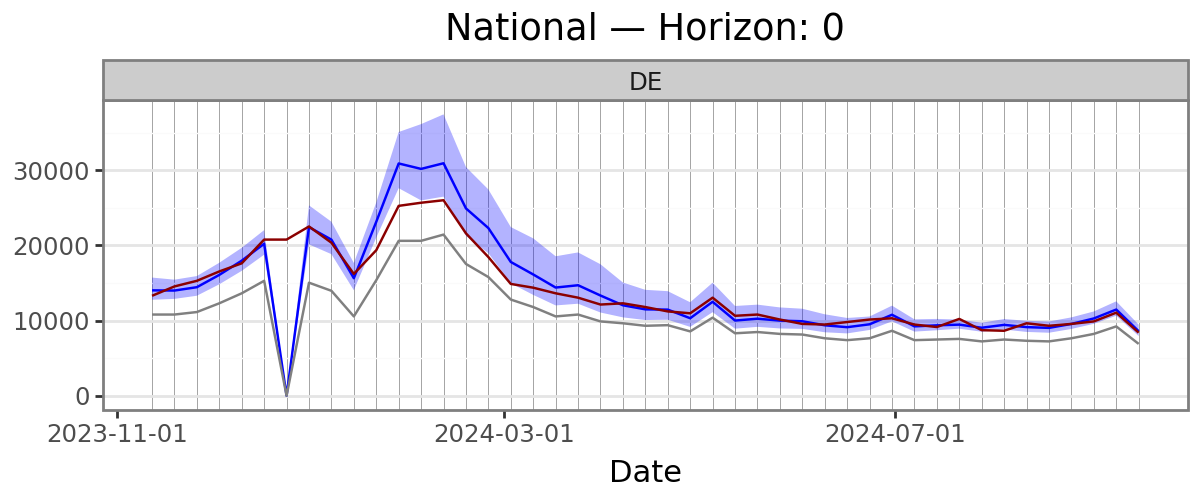

In [12]:
plot_nowcasts(df_plot)

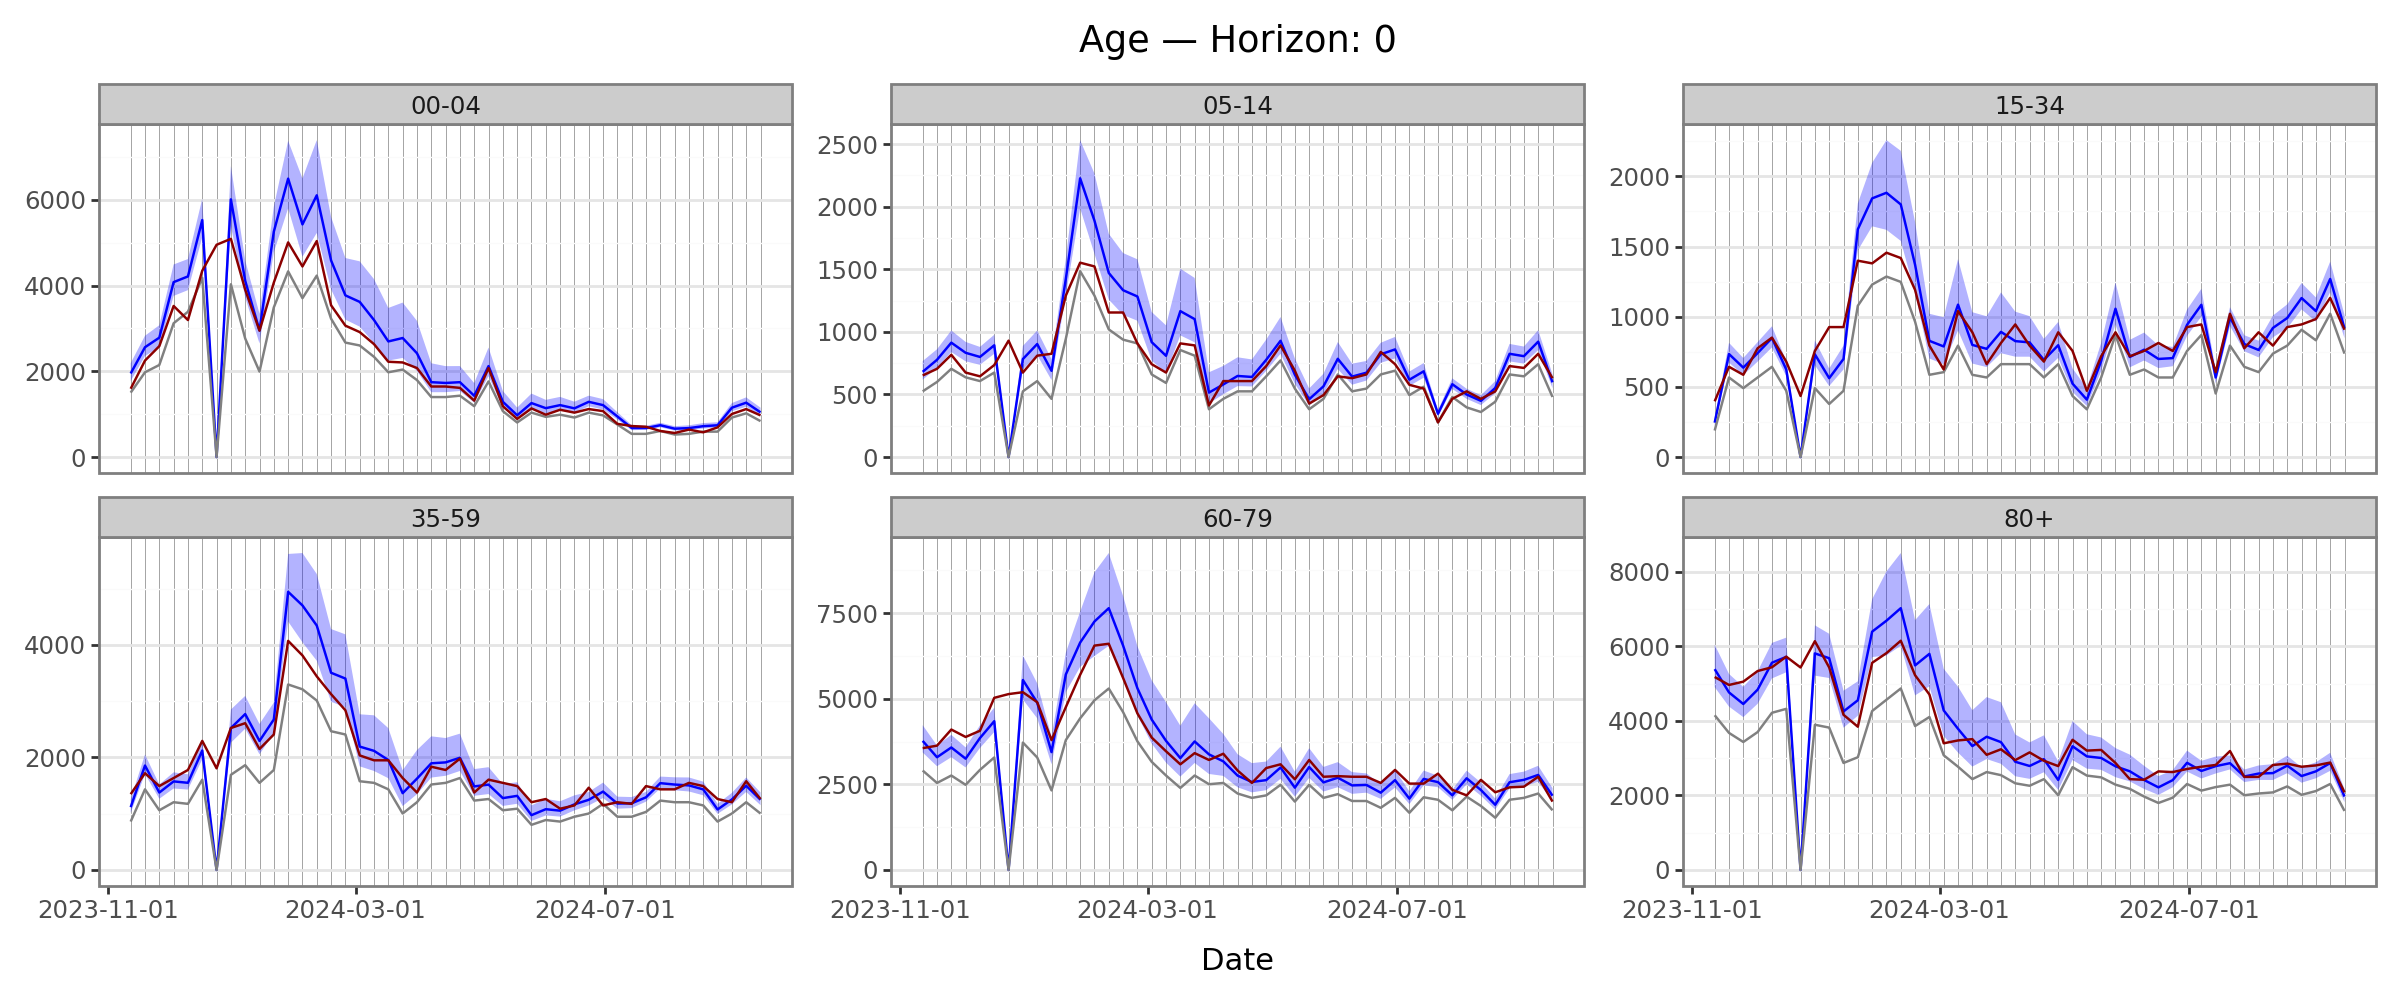

In [13]:
plot_nowcasts(df_plot, 'age')

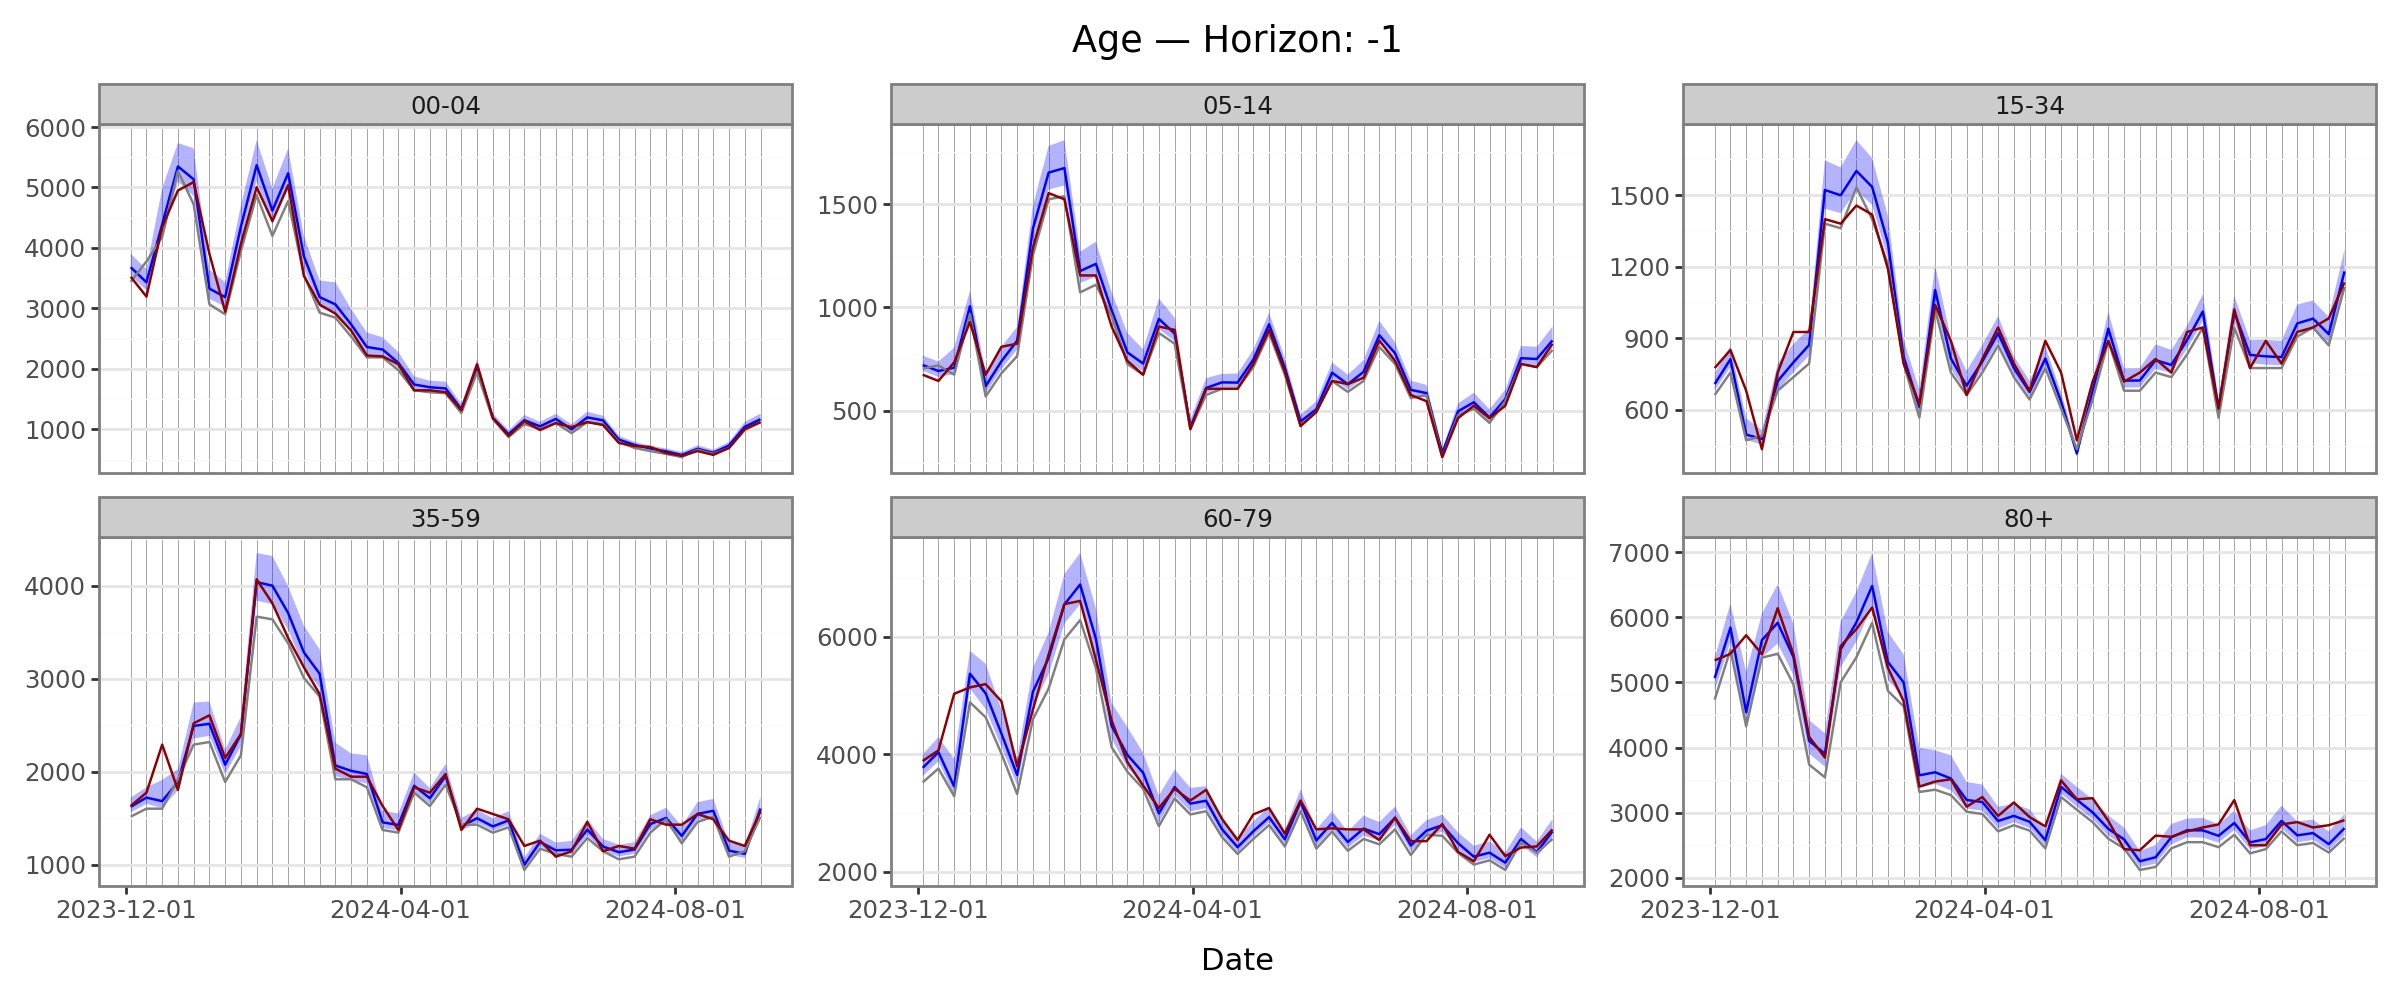

In [15]:
plot_nowcasts(df_plot, 'age', -1)

In [14]:
plot_data = df_plot.copy()

In [15]:
df_frozen = pd.DataFrame()
for h in [0, -1, -2, -3]:
    df_temp = load_frozen_values(h)
    df_temp['horizon'] = h
    df_frozen = pd.concat([df_frozen, df_temp])

In [16]:
plotnine.options.figure_size = (12, 5)
df_temp = plot_data[(plot_data.location == 'DE') & (plot_data.age_group == '00+')]
frozen_temp = df_frozen[(df_frozen.location == 'DE') & (df_frozen.age_group == '00+')]
facet = 'location'
ncol = 1

In [17]:
y_temp = df_temp[df_temp.type == 'truth']

In [18]:
y_temp = pd.concat([y_temp.assign(horizon=h) for h in [0, -1, -2, -3]], ignore_index=True)

In [19]:
df_temp = df_temp[df_temp.type != 'truth']
y_temp = y_temp[y_temp.target_end_date.between(df_temp.target_end_date.min(), df_temp.target_end_date.max())]
frozen_temp = frozen_temp[frozen_temp.date.between(df_temp.target_end_date.min(), df_temp.target_end_date.max())]
# Get all Sundays within the range of the dataset
sundays = get_sundays(df_temp['target_end_date'].min(), df_temp['target_end_date'].max())

In [151]:
# df_temp.horizon = df_temp.horizon.astype(str)

In [152]:
# df_temp['horizon'] = pd.Categorical(df_temp['horizon'], categories=['0', '-1', '-2', '-3'], ordered=True)

In [153]:
# df_temp = df_temp.sort_values(by='horizon', ascending=True, ignore_index=True)

In [154]:
# df_temp['horizon'] = df_temp['horizon'].cat.reorder_categories(
#     ['0', '-1', '-2', '-3']
# )

In [20]:
df_temp.horizon.unique()

array([-3, -2, -1,  0])

In [21]:
facet = 'horizon'

In [22]:
stratum = 'national'

In [23]:
ncol = 2

In [24]:
p = (
    ggplot(df_temp, aes(x='target_end_date')) +
    facet_wrap(facet, ncol=ncol, scales='free_y', labeller=lambda x: 'Horizon: ' + str(x)) + # + (' weeks' if x != '-1' else ' week')) +
    geom_ribbon(aes(ymin='quantile_0.05', ymax='quantile_0.95'), 
                fill='blue', alpha=0.3) +
    geom_line(aes(y='quantile_0.5'), color='blue') +
    geom_line(frozen_temp, aes(x='date', y='value', color="'frozen'")) +
    geom_line(y_temp, aes(x='target_end_date', y='quantile_0.5', color="'final'")) +
    # geom_point(y_temp, aes(x='target_end_date', y='quantile_0.5'), size=0.75) +
    scale_color_manual(name="Truth", values={
        "final": "darkred",
        "frozen": "gray"
    }, labels={
        'frozen': 'At time of nowcast', 
        'final':'Final'
    }) +
    scale_x_date(
        date_breaks='4 months',
        # breaks=[pd.Timestamp('2024-01-01'), pd.Timestamp('2024-03-01'), pd.Timestamp('2024-05-01')],
        minor_breaks=sundays  # Add minor ticks at every Sunday
    ) +
    labs(x='', y='', title='National level') +
    theme_bw() +
    theme(
        panel_grid_major_x=element_blank(),
        panel_grid_major_y=element_blank(),
        panel_grid_minor_y=element_blank(),
        panel_grid_minor=element_blank(),
        #panel_grid_minor=element_line(color='grey', size=0.5)
        #panel_grid_minor_x=element_line(color='grey', size=0.1),
        legend_key=element_blank()
    )
)

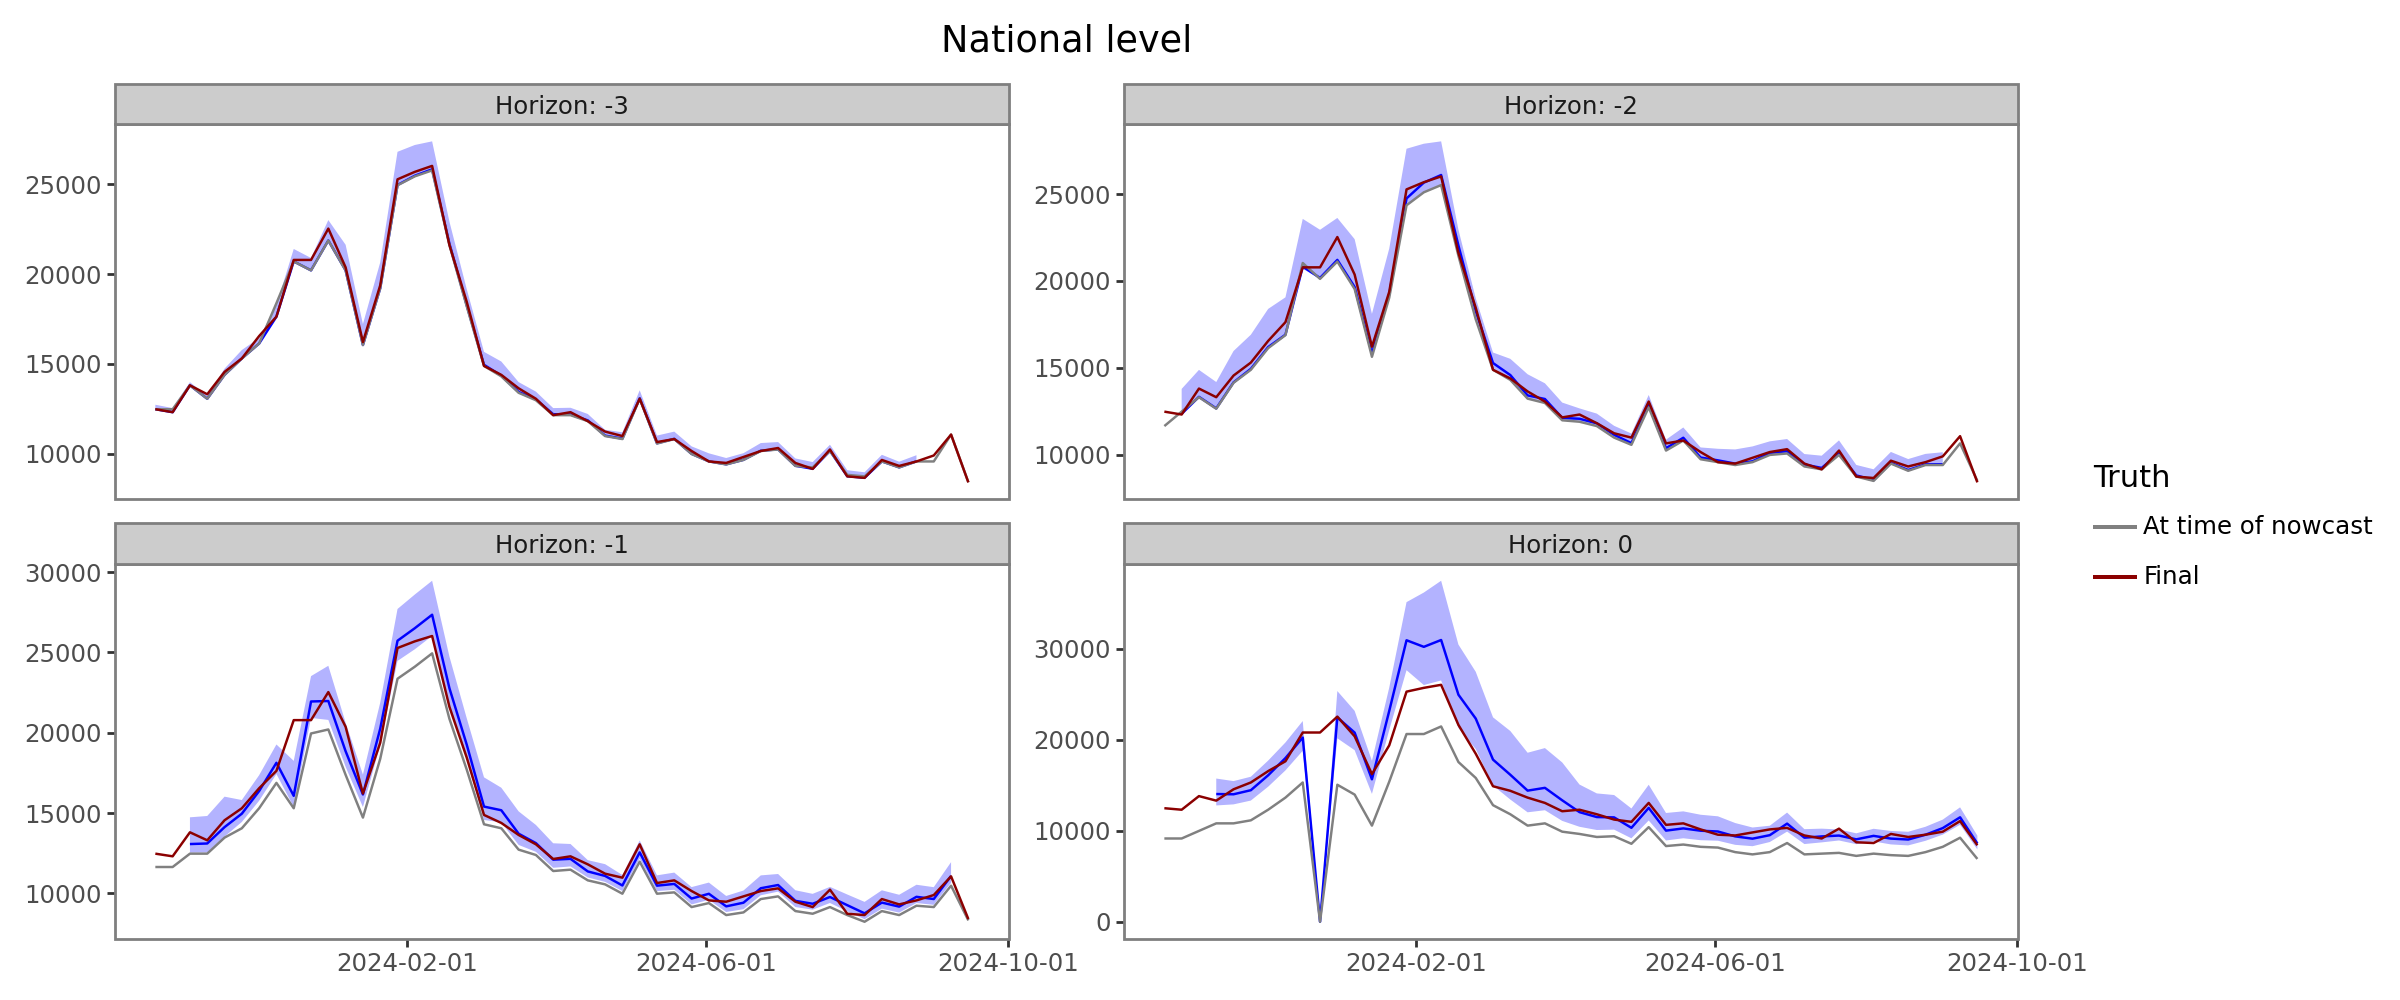

In [25]:
p

In [26]:
p.save("../figures/nowcasts_national.pdf", width = 190.5, height = 90, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 190.5 x 90.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/nowcasts_national.pdf
